---
authors: Roel Smit
---

# Thermostaat

In het vorige werkblad heb je gezien hoe een gas zich gedraagt in een zuiger waarbinnen wordt voldaan aan de wet van behoud van energie.
In dat geval geldt $p \propto \alpha V^{-k}$, waarbij $k$ een exponent is die wordt bepaald door de vrijheidsgraden van het gas - in onze simulatie werken we met mono-atomaire gassen in 2D. 

We hadden kunnen denken dat we de ideale gaswet zouden kunnen gebruiken.
Echter, de temperatuur van het gas verandert door de werking van de zuiger - deze verricht arbeid. 

Het meenemen van arbeid dat verricht wordt door, of op, het gas is een eerste uitbreiding die belangrijk is in Thermodynamica.
Uitwisseling van energie (toevoegen of afvoeren van warmte) is een tweede uitbreiding.
In deze simulatie onderzoeken we die uitbreiding waarbij we warmte aan en af voeren uit het controlevolume.
Op die manier kunnen we ook isotherme simulaties doen.

Eerst herhalen we de nodige ingrediënten:

- klasse voor het deeltje met bijbehorende functies
- variabelen en randcondities van controle volume
- functies voor een lijst deeltjes

Daarna voegen we de code toe voor het warmtecontact:

- introduceren thermostaat

En vervolgens
- bestuderen isotherm proces

## Laden van eerdere code

De pakketten van Python en de constanten voor de simulatie:

```{exercise} constanten
:label: ex-thermostat-01
Neem de constanten die je in het vorige werkblad hebt gekozen hieronder over.
```


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.optimize import curve_fit

N = 40                       # Aantal deeltjes
BOX_SIZE_0 = 10     #nm           # Hoogte en lengte startvolume
V_0 = 1             #nm/2.5ps                      # Startsnelheid van deeltjes
RADIUS = 0.3        #nm                   # Straal van moleculen
DT = 0.1*RADIUS/V_0                     # Tijdstap om geen botsing te missen
M = 4.81e-26
kB = 1.380649 * 10**(-23)
# deze waardes woorden gegeven op brightspace - ik ben van het fijt bewust dat deze wardes geen fietsband representeren
V_PISTON_0 = -0.1 * V_0      # Startsnelheid van zuiger

# (negatief betekent zowel links als rechts naar binnen gericht)

BOX_Size_0_scale = 1e-9
V_0_scale = (1e-9)/(2.5e-12)
RADIUS_scale = 1e-9 
DT_scale = RADIUS_scale/V_0_scale
particle_momentum_scale = V_0_scale
T_scale = V_0_scale**2 
p_scale = particle_momentum_scale/(BOX_Size_0_scale*DT_scale)
w_scale = V_0_scale**2
q_scale = V_0_scale**2

De klasse voor het gasmolecuul met de interacties:

In [2]:
class ParticleClass:
    def __init__(self, m, v, r, R):
        """ maakt een deeltje (constructor) """
        self.m = m                         
        self.v = np.array(v, dtype=float)  
        self.r = np.array(r, dtype=float)   #position
        self.R = R                          #radius

    def update_position(self):
        """ verandert positie voor één tijdstap """
        self.r += self.v * DT 
            
    @property
    def momentum(self):
        return self.m * self.v
    
    @property
    def kin_energy(self):
        return 1/2 * self.m * np.dot(self.v, self.v)
    
def collide_detection(p1: ParticleClass, p2: ParticleClass) -> bool:
    """ Geeft TRUE als de deeltjes overlappen """
    return np.linalg.norm(p1.r - p2.r) < (p1.R + p2.R)


def particle_collision(p1: ParticleClass, p2: ParticleClass):
    """ past snelheden aan uitgaande van overlap """
    m1, m2 = p1.m, p2.m
    delta_r = p1.r - p2.r
    delta_v = p1.v - p2.v
    dot_product = np.dot(delta_r, delta_v)
    # Als deeltjes van elkaar weg bewegen dan geen botsing
    if dot_product >= 0: # '='-teken voorkomt ook problemen als delta_r == \vec{0}
        return
    distance_squared = np.dot(delta_r, delta_r) 
    # Botsing oplossen volgens elastische botsing in 2D
    p1.v -= 2 * m2 / (m1 + m2) * dot_product / distance_squared * delta_r
    p2.v += 2 * m1 / (m1 + m2) * dot_product / distance_squared * delta_r

De randvoorwaarde van het volume. Hierbij is rekening gehouden met een bewegende zuiger die in het vorige werkblad is toegevoegd.

In [3]:
def top_down_collision(particle: ParticleClass):
    global impulse_outward, box_height
    if abs(particle.r[1]) + particle.R > box_height / 2:
        particle.r[1] = np.sign(particle.r[1]) * (box_height/2 - particle.R)
        impulse_outward += abs(particle.momentum[1]) * 2
        particle.v[1] *= -1

def left_right_collision(particle: ParticleClass):
    """ verzorgen van botsingen met wand links en rechts, die als zuiger kunnen bewegen """
    global box_length, v_piston, impulse_outward, work
    if abs(particle.r[0]) + particle.R > box_length / 2:
        particle.r[0] = np.sign(particle.r[0]) * (box_length/2 - particle.R)
        piston_velocity = np.sign(particle.r[0]) * v_piston
        relative_velocity = particle.v[0] - piston_velocity  # stelsel zuiger
        particle.v[0] = -relative_velocity + piston_velocity # stelsel waarnemer
        impulse_outward += 2 * particle.m * abs(relative_velocity)
        work += 2 * particle.m * relative_velocity * piston_velocity

De functies voor het uitvoeren van de functies over de gehele lijst met deeltjes, waarbij we de werking van de zuiger ook hebben meegenomen:

```{exercise} temperatuur
:label: ex-thermostat-02
Pas de code voor de functie `temperature` aan naar de functie die je op de vorige werkbladen hebt gebruikt.
```

In [4]:
def create_particles(particles):
    """ Leegmaken en opnieuw aanmaken van deeltjes  in lijst """
    global box_length, box_height
    particles.clear()
    for _ in range(N):
        vx = np.random.uniform(-V_0, V_0)
        vy = np.random.choice([-1, 1]) * np.sqrt(V_0**2 - vx**2)        
        x = np.random.uniform(-box_length/2 + RADIUS, box_length/2 - RADIUS)
        y = np.random.uniform(-box_height/2 + RADIUS, box_height/2 - RADIUS)
        particles.append(ParticleClass(m=1.0, v=[vx, vy], r=[x, y], R=RADIUS))
    
def temperature(particles) -> float:
    temp = 0.0
    vq = np.array([]) 
    for p in particles:
        vq = np.append(vq, p.v[0]**2+p.v[1]**2)
    avv_vq = np.mean(vq)
    return (M*avv_vq)/(2*kB)
        
def handle_collisions(particles):
    """ alle onderlinge botsingen afhandelen voor deeltjes in lijst """
    num_particles = len(particles)
    for i in range(num_particles):
        for j in range(i+1, num_particles):
            if collide_detection(particles[i], particles[j]):
                particle_collision(particles[i], particles[j])

def handle_walls(particles):
    """ botsing met wanden controleren voor alle deeltjes in lijst en gemiddeld bepaling druk """
    global pressure, impulse_outward, box_height, box_length   # om pressure buiten de functie te kunnen gebruiken
    impulse_outward = 0.0
    for p in particles:
        left_right_collision(p)
        top_down_collision(p)    
    pressure = 0.95 * pressure + 0.05 * impulse_outward / ((2 * box_length + 2 * box_height) * DT) 
    
def take_time_step(particles):
    """ zet tijdstap voor een lijst deeltjes en verwerk alle botsingen onderling en met wanden """
    global box_length, v_piston
    box_length += 2 * v_piston * DT # zowel links als rechts zuiger
    for p in particles:
        p.update_position()
    handle_collisions(particles)
    handle_walls(particles)  


## Test code

Voordat we de code aanpassen controleren we eerst of alles het doet. Hiervoor maken we zowel een $P,V$-diagram als een $T,V$-diagram (met als toevoeging een $P,T$-diagram) tijdens de werking van de zuiger. Let op! De eenheden van deze grafiek kunnen niet kloppen omdat er niet in verrekend zit welke constanten jij hebt gekozen. 

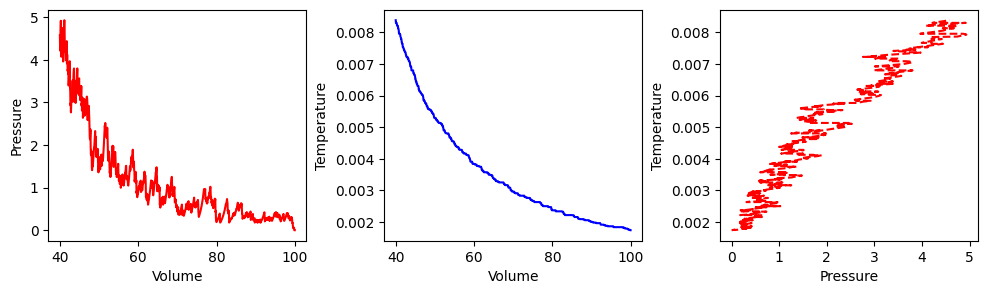

In [5]:
particles = []
volumes = np.zeros(1000, dtype=float)
pressures = np.zeros(1000, dtype=float)
temperatures = np.zeros(1000, dtype=float)
# times = np.linspace(1, 100, 100)

pressure = 0.0
work = 0.0
box_height = BOX_SIZE_0
box_length = BOX_SIZE_0         # zetten zuiger terug
v_piston = V_PISTON_0
create_particles(particles)     # resetten deeltjes 
for i in range(1000):
    take_time_step(particles)
    volumes[i] = box_length * box_height
    pressures[i] = pressure
    temperatures[i] = temperature(particles)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))
ax1.set_xlabel('Volume')
ax1.set_ylabel('Pressure')
ax2.set_xlabel('Volume')
ax2.set_ylabel('Temperature')
ax3.set_xlabel('Pressure')
ax3.set_ylabel('Temperature')

fig.tight_layout

ax1.plot(volumes, pressures, '-r')
ax2.plot(volumes, temperatures, '-b')
ax3.plot(pressures, temperatures, 'r--')
plt.subplots_adjust(wspace=0.3)      # afstand tussen subplots
plt.show()

We zien inderdaad de druk, $P \propto V^{-k}$, met een exponent $k > 1$, wat verklaard wordt door de toename van de temperatuur tijdens het proces. 

Maar wat gebeurt er wanneer we de temperatuur van het gas constant houden? Als we dat doen kunnen we controleren of de druk inderdaad invers proportioneel is met het volume, zoals de gaswet voorschrijft. 

## De thermostaat

In de werkelijkheid is de temperatuur van de wand een mate van de amplitude van de trillingen van de deeltjes waaruit de wand bestaat.
De wederzijdse overdracht van de energie van die trillingen naar de kinetische energie van de gasmoleculen bepaalt het thermische contact tussen de wanden van het volume en het gas.
In ons model bestaat de wand echter helemaal niet uit deeltjes maar hebben we een denkbeeldige lijn getrokken in de ruimte.
We moeten daarom een wiskundige truc toepassen om de temperatuur van het gas te beïnvloeden. 

Er zijn in de literatuur verschillende van dit soort trucs bedacht.
Ze worden een 'thermostaat' genoemd.
Elk van die type trucs hebben hun voor- en nadelen.
In ons geval houden we het simpel: Op het moment dat een gasmolecuul botst met de wand (die een thermisch contact voorstelt), dan schalen we de snelheid van dit molecuul met (de wortel van) de verhouding tussen de veronderstelde temperatuur van de wand en de temperatuur die het gas op dat moment heeft:

$$
  v = \sqrt{ \frac{T_{wand}} {T_{deeltje}} }v
$$

Voor het gemak houden we de linker en rechter wand van het volume als zuiger en maken we het thermische contact aan de onder- en bovenwand.

In [6]:
def top_down_collision(particle: ParticleClass) -> None:
    """ verzorgen van botsingen met wand boven en onder, die als thermostaat kunnen werken """
    global box_height, set_temp, impulse_outward, heat
    if abs(particle.r[1]) + particle.R > box_height / 2:
        # Als de afstand van de horizontale as plus de radius groter is dan de afstand van de muur tot de horizontale as wordt deze functie uitgevoerdt. (Het deeltje raakt de boven of onder muur)
        temp_factor = (set_temp/temperature(particles)) if set_temp > 0 else 1.0 
        # Als set_temp bestaat wordt temp_factor berekend. Als set_temp = 0 is blijft temp_factor = 1 daarmee de temperatuur niet verandert.
        particle.r[1] = np.sign(particle.r[1]) * (box_height/2 - particle.R)
        impulse_outward += abs(particle.momentum[1]) * (1 + temp_factor**0.5) 
        heat += particle.kin_energy * (temp_factor - 1)
        particle.v *= temp_factor**0.5
        particle.v[1] *= -1

```{exercise} uitleg thermostaat
:label: ex-thermostat-03
Leg bij elke regel na het eerste if-statement uit (in een enkele zin) waarom deze regel zo is gecodeerd. 
Leg de regels hieronder uit, maar voeg ook comments toe in bovenstaande code. 
```

```{solution} ex-thermostat-03
if-statement 1
# Als de afstand van de horizontale as plus de radius groter is dan de afstand van de muur tot de horizontale as wordt deze functie uitgevoerdt. (Het deeltje raakt de boven of onder muur)
if-statement 2
# Als set_temp bestaat wordt temp_factor berekend. Als set_temp = 0 is blijft temp_factor = 1 daarmee de temperatuur niet verandert.
if-statement 2
```


Met deze nieuwe definitie van de functies, draaien we een simulatie waarin we zowel de temperatuur als de druk plotten als functie van het volume.

```{warning}
Deze simulatie bevat vanwege de tragere zuiger een veel groter aantal tijdstappen .
Daarom zal deze simulatie ook langer duren.
Maak je geen zorgen als het een minuut duurt om de berekening te voltooien.
```

Om verdere belasting van de processor tot een minimum te beperken, berekent deze simulatie ook alvast de totale warmte $Q$ en de totale arbeid $W$ tijdens het proces.
Deze worden opgeslagen in de arrays `heats` en `works`.
We zullen de resultaten van deze simulatie voor een aantal vervolgstappen gebruiken. 

0
500
1000
1500
2000
2500
3000
3500
4000
4500


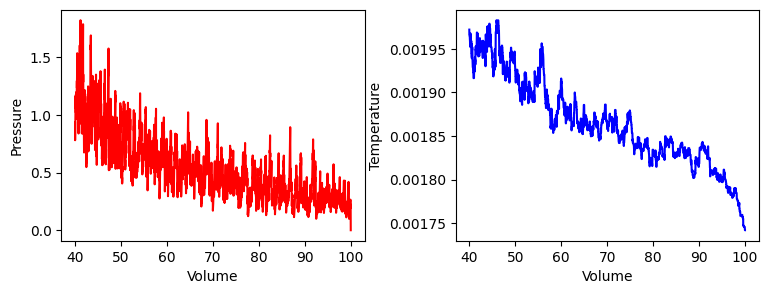

In [7]:
particles = []
N_steps = 5000
volumes = np.zeros(N_steps, dtype=float)
pressures = np.zeros(N_steps, dtype=float)
temperatures = np.zeros(N_steps, dtype=float)
heats = np.zeros(N_steps, dtype=float)
works = np.zeros(N_steps, dtype=float)

pressure = 0.0
work = 0.0
heat = 0.0
box_height = BOX_SIZE_0
box_length = BOX_SIZE_0         # zetten zuiger terug
v_piston = 0.2 * V_PISTON_0
create_particles(particles)     # resetten deeltjes 
set_temp = temperature(particles)

for i in range(N_steps):
    take_time_step(particles)
    volumes[i] = box_length * box_height
    pressures[i] = pressure
    temperatures[i] = temperature(particles)
    heats[i] = heat
    works[i] = work
    if i%500==0:
        print(i)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))
ax1.set_xlabel('Volume')
ax1.set_ylabel('Pressure')
ax2.set_xlabel('Volume')
ax2.set_ylabel('Temperature')
fig.tight_layout

ax1.plot(volumes, pressures, '-r')
ax2.plot(volumes, temperatures, '-b')

plt.subplots_adjust(wspace=0.3)   
plt.show()

```{exercise} fit P,V-diagram
:label: ex-thermostat-04
Maak een fit van het $(P,V)$-diagram uit de laatste simulatie.
(Maak dus niet een nieuwe simulatie, maar gebruik de gegevens van de vorige) De fit-functie hiervoor is alvast gegeven.
De correcte parameters die uit deze fit volgen zijn sterk afhankelijk van de constanten die je aan de start van dit werkblad gekozen hebt.
Je moet dus actief moeten zoeken naar de juiste startwaarden voor de fit om een werkbaar antwoord te krijgen.
Maak daarom weer gebruik van van de extra optie `p0=` in de argumenten van de functie `curve_fit`.
```

````{tip}
:class: dropdown
Het zelfstandig afschatten van `p0` is lastig, maar omdat de relatie tussen $p$ en $V$ bekend is, kunnen we wel een eerste stap maken door twee van onze metingen te nemen ($p_0$ en $p_1$ en $V_0$ en $V_1$), delen we die waarden door elkaar en nemen we links en rechts de logaritme krijgen we:

$$
  log(\frac{p_0}{p_1})=log(\frac{V_0}{V_1})(-n)
$$

Zo hebben we een schatting ($n_{init}$) voor $n$ gevonden. Door die waarde nu te substitueren vinden we een initiele guess ($a_{init}$) voor de waarde van $a$:

$$
  a = p_0V_0^{n_{init}}
$$

Let op het - teken!
Waar we nog verder rekening mee moeten houden is dat een verkeerde waarde voor $n_{init}$ kan zorgen voor hele grote fouten in $a_{init}$ omdat die exponentieel mee telt.
Omdat $p$ en $V$ fluctueren door het gering aantal deeltjes kunnen we beter waarden voor sampelen waarbij we een keuze maken moeten tussen grotere sample size voor reduceren van ruis en kleine sampele size om het effect van de zuiger klein te houden:

```python
p0 = np.mean(pressures[100:110])
p1 = np.mean(pressures[N:N+10])
V0 = np.mean(volumes[100:110])
V1 = np.mean(volumes[N:N+10])

n_init = -np.log(p0/p1) / np.log(V0/V1)
a_init = p0 * V0**(-n_init)
```
```` 

In [8]:
p0 = np.mean(pressures[100:110])
p1 = np.mean(pressures[-10:])
V0 = np.mean(volumes[100:110])
V1 = np.mean(volumes[-10:])

n_init = -np.log(p0/p1) / np.log(V0/V1)
a_init = p0 * V0**(n_init)
print(n_init)
print(a_init)

1.2441155191553248
92.77430920734672


[476.92368231  -1.63281871]


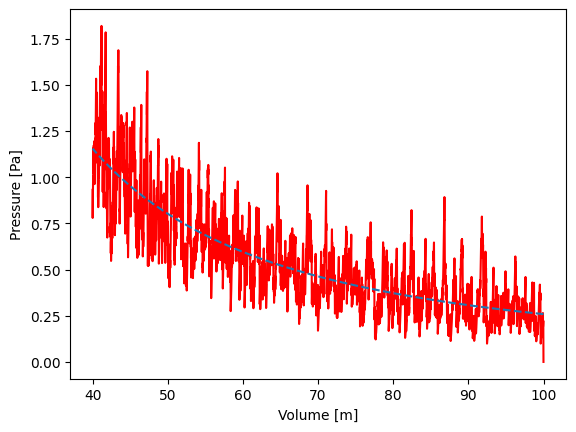

In [9]:
def power_law(vol, a, n):
    return a * vol**n    

val, cov = curve_fit(power_law,volumes,pressures)
print(val)

plt.figure()
plt.xlabel('Volume [m]')
plt.ylabel('Pressure [Pa]')

pressures = np.asarray(pressures)

plt.plot(volumes, pressures, '-r')
plt.plot(volumes, power_law(volumes, *val), '--')

plt.show()


1.6000000000000003e+23
[ 1.00000000e+05 -1.10902888e+00]


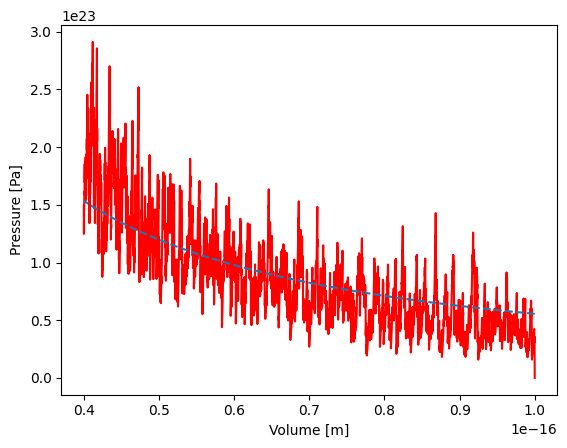

In [10]:
def power_law(vol, a, n):
    return a * vol**n    

val, cov = curve_fit(power_law,volumes*BOX_Size_0_scale**2,pressures*p_scale, p0=(1000000,-1.1),bounds=((100000,-1.2),(1000000,-1)))
print(p_scale)
print(val)

plt.figure()
plt.xlabel('Volume [m]')
plt.ylabel('Pressure [Pa]')

pressures = np.asarray(pressures)

plt.plot(volumes*BOX_Size_0_scale**2, pressures*p_scale, '-r')
plt.plot(volumes*BOX_Size_0_scale**2, power_law(volumes*BOX_Size_0_scale**2, *val), '--')
#plt.plot(volumes*BOX_Size_0_scale**2, power_law(volumes*BOX_Size_0_scale**2, 5000000000000,-), '--')
plt.show()


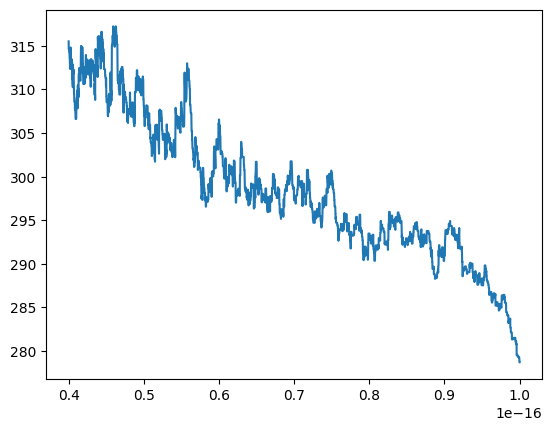

In [11]:
# temperatuur over volume
plt.figure()
plt.plot(volumes*BOX_Size_0_scale**2, temperatures*T_scale, '-')
plt.show()

Je ziet dat de exponent van dit $(P,V)$-diagram net niet overeenkomt met de ideale verwachting. 

```{exercise} afwijking
:label: ex-thermostat-05
Het $(P,V)$-diagram is niet perfect invers proportioneel door de verandering van de temperatuur.
Verklaar dat de temperatuur nooit helemaal terugkeert naar de beginwaarde vanuit de dynamische beweging van de gasmoleculen. 
```

```{solution} ex-thermostat-05
De temperatuur neemt toe omdat de snelheid van de deeltjes toeneemt als zij met de bewegende muren botsen. Arbeid werdt in inwendige energie omgevormt.
```

Als je goed kijkt zie je dat de temperatuur voor kleinere volumes een steeds grotere afwijking vertoont. 

```{exercise} falende thermostaat
:label: ex-thermostat-06
Als je ervan uit kan gaan dat de afvoer van warmte evenredig is met het verschil tussen de starttemperatuur en de actuele temperatuur, verklaar dan waarom de temperatuur toeneemt voor kleine volumes.
```

```{solution} ex-thermostat-06
De deeltjes worden versneldt door de muren links en rechts, die steeds dichter bij elkaar komen, maar ze verliezen alleen snelheid als zij met de muren boven en beneden botsen. Deze laatste twee muren worden steeds kleiner. Daarom is de kans groter dat de deeltjes met de bewegende muren botsen en versnelldt worden dan met de afkoelende muren botsen en afgeremdt worden. Het gevolg is een toenemende temperatuur.
```

Al met al lijkt het resultaat van de simulatie er redelijk uit te zien.
Maar om een sterkere indicatie te hebben dat de simulatie correct is, moeten we weer een goede test verzinnen om de simulatie te verifiëren.
In dit geval kunnen we opnieuw controleren of de simulatie voldoet aan de eerste hoofdwet.

```{exercise} eerste hoofdwet herhaald
:label: ex-thermostat-07
Maak een grafiek die zichtbaar maakt dat de simulatie inderdaad voldoet aan de eerste hoofdwet (of niet).
Als de code hierboven klopt, zijn de tekens voor arbeid en warmte in overeenstemming met de definitie van het boek.
Let hierbij vooral goed op je eenheden.
Om het jezelf makkelijker te maken kun je de verschillende grootheden onafhankelijk van elkaar plotten en de resultaten controleren, voordat je de definitieve grafiek opstelt.  
```

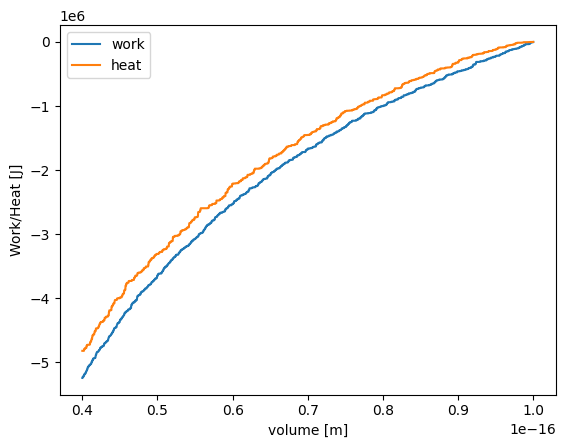

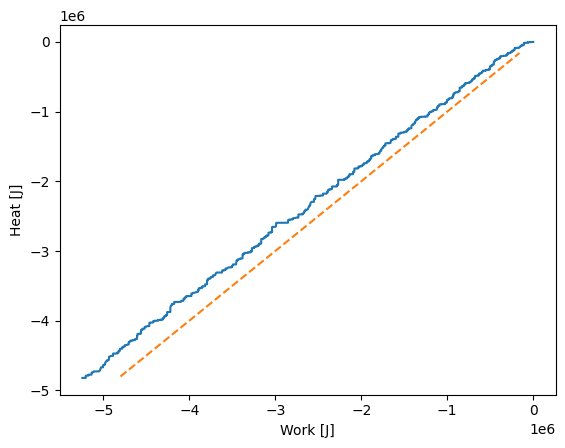

In [12]:
#your code/answer
# 1. Hoofdwet voor steady state: Q=W
plt.figure()
plt.plot(volumes*BOX_Size_0_scale**2, works*w_scale,'-', label='work')
plt.plot(volumes*BOX_Size_0_scale**2, heats*q_scale,'-', label='heat')
plt.xlabel('volume [m]')
plt.ylabel('Work/Heat [J]')
plt.legend()
plt.show()
# in de plot is te zien dat Q~=W

# expectation: y=x relation
plt.figure()
plt.plot(works*w_scale,heats*q_scale,'-', label = 'simulation')
x=np.arange(-30,0,1)
plt.plot(x*q_scale,x*q_scale,'--', label = 'exception')
plt.xlabel('Work [J]')
plt.ylabel('Heat [J]')
plt.show()



In het boek wordt uitgelegd dat er maar twee vormen van energieoverdracht zijn van een systeem naar de omgeving. Dit kan via warmteoverdracht of via arbeid.
Bijzonder is dat deze beide grootheden alleen de snelheid van de moleculen beïnvloeden.
Toch zullen we in het volgende werkblad zien dat er een fundamenteel verschil zit in de werking van deze twee macroscopische grootheden. 

```{exercise}
Push je werk naar GitHub of ga door met de uitbreiding voor een beoordeling excellent.
```

```{exercise} 🌶 Uitbreiding
In bovenstaande simulatie zijn de onder- en bovenwand allebei een thermostaat die naar dezelfde temperatuur toewerken.
Als we die temperaturen verschillend maken, kunnen we kijken naar de thermische geleiding van het gas. 

- Maak nu een nieuwe simulatie met een volume met dezelfde breedte maar vier keer de hoogte, waarin de zuiger stilstaat. 
- Hou de dichtheid van de deeltjes hetzelfde, dus breid het aantal deeltjes uit naar 160. 
- Zet de temperatuur van de bovenwand op 150% en die van de onderwand op 50% van de starttemperatuur. 
- Door het warmtecontact via de bovenwand en de onderwand apart te rekenen, kan je zien hoeveel warmte er door het volume heenstroomt.
- Controller of deze warmtestroom evenredig is met het temperatuurverschil en omgekeerd evenredig met de afstand. (nogmaals: hou de dichtheid van de deeltjes constant)
- Geef de warmtegeleidingscoëfficiënt in W/K van het ideaalgas in je simulatie. (Opmerking: De warmtegeleidingscoëfficiënt wordt normaal gegeven in W/mK, maar in onze tweedimensionale simulatie valt de lengteafhankelijkheid er uit)
```

In [ ]:
N = 160                       # Aantal deeltjes
BOX_SIZE_0 = 10     #nm           # Hoogte en lengte startvolume
V_0 = 1             #nm/2.5ps                      # Startsnelheid van deeltjes
RADIUS = 0.3        #nm                   # Straal van moleculen
DT = 0.1*RADIUS/V_0                     # Tijdstap om geen botsing te missen
M = 4.81e-26
kB = 1.380649 * 10**(-23)
# deze waardes woorden gegeven op brightspace - ik ben van het fijt bewust dat deze wardes geen fietsband representeren
V_PISTON_0 = 0    # Startsnelheid van zuiger

# (negatief betekent zowel links als rechts naar binnen gericht)

BOX_Size_0_scale = 1e-9
V_0_scale = (1e-9)/(2.5e-12)
RADIUS_scale = 1e-9 
DT_scale = RADIUS_scale/V_0_scale
particle_momentum_scale = V_0_scale
T_scale = V_0_scale**2 
p_scale = particle_momentum_scale/(BOX_Size_0_scale*DT_scale)
w_scale = V_0_scale**2
q_scale = V_0_scale**2


volumes = np.zeros(1000, dtype=float)
pressures = np.zeros(1000, dtype=float)
temperatures = np.zeros(1000, dtype=float)
heats_b = np.zeros(1000, dtype=float)
heats_t = np.zeros(1000, dtype=float)
times = np.linspace(1, 1000, 1000)

pressure = 0.0
work = 0.0
heat_b = 0.0
heat_t = 0.0
box_height = 4* BOX_SIZE_0
box_length = BOX_SIZE_0         # zetten zuiger terug
v_piston = V_PISTON_0

class ParticleClass:
    def __init__(self, m, v, r, R):
        """ maakt een deeltje (constructor) """
        self.m = m                         
        self.v = np.array(v, dtype=float)  
        self.r = np.array(r, dtype=float)   #position
        self.R = R                          #radius

    def update_position(self):
        """ verandert positie voor één tijdstap """
        self.r += self.v * DT 
            
    @property
    def momentum(self):
        return self.m * self.v
    
    @property
    def kin_energy(self):
        return 1/2 * self.m * np.dot(self.v, self.v)
    
def collide_detection(p1: ParticleClass, p2: ParticleClass) -> bool:
    """ Geeft TRUE als de deeltjes overlappen """
    return np.linalg.norm(p1.r - p2.r) < (p1.R + p2.R)


def particle_collision(p1: ParticleClass, p2: ParticleClass):
    """ past snelheden aan uitgaande van overlap """
    m1, m2 = p1.m, p2.m
    delta_r = p1.r - p2.r
    delta_v = p1.v - p2.v
    dot_product = np.dot(delta_r, delta_v)
    # Als deeltjes van elkaar weg bewegen dan geen botsing
    if dot_product >= 0: # '='-teken voorkomt ook problemen als delta_r == \vec{0}
        return
    distance_squared = np.dot(delta_r, delta_r) 
    # Botsing oplossen volgens elastische botsing in 2D
    p1.v -= 2 * m2 / (m1 + m2) * dot_product / distance_squared * delta_r
    p2.v += 2 * m1 / (m1 + m2) * dot_product / distance_squared * delta_r

def top_down_collision(particle: ParticleClass) -> None:
    """ verzorgen van botsingen met wand boven en onder, die als thermostaat kunnen werken """
    global box_height, set_temp_t, set_temp_b, impulse_outward, heat_t, heat_b
    if particle.r[1] + particle.R > box_height / 2 or particle.r[1] - particle.R < -box_height / 2:
        # Als de afstand van de horizontale as plus de radius groter is dan de afstand van de muur tot de horizontale as wordt deze functie uitgevoerdt. (Het deeltje raakt de boven of onder muur)
        if particle.r[1] + particle.R > box_height / 2:
            temp_factor = (set_temp_t/temperature(particles)) #if set_temp_t > 0 else 1.0
            heat_t += particle.kin_energy * (temp_factor - 1)
            heat_b += 0
        elif particle.r[1] - particle.R < -box_height / 2:
            temp_factor = (set_temp_b/temperature(particles)) #if set_temp_b > 0 else 1.0
            heat_b += particle.kin_energy * (temp_factor - 1)
            heat_t += 0
        # Als set_temp bestaat wordt temp_factor berekend. Als set_temp = 0 is blijft temp_factor = 1 daarmee de temperatuur niet verandert.
        particle.r[1] = np.sign(particle.r[1]) * (box_height/2 - particle.R)
        impulse_outward += abs(particle.momentum[1]) * (1 + temp_factor**0.5) 
        particle.v *= temp_factor**0.5
        particle.v[1] *= -1

def left_right_collision(particle: ParticleClass):
    """ verzorgen van botsingen met wand links en rechts, die als zuiger kunnen bewegen """
    global box_length, v_piston, impulse_outward, work
    if abs(particle.r[0]) + particle.R > box_length / 2:
        particle.r[0] = np.sign(particle.r[0]) * (box_length/2 - particle.R)
        piston_velocity = np.sign(particle.r[0]) * v_piston
        relative_velocity = particle.v[0] - piston_velocity  # stelsel zuiger
        particle.v[0] = -relative_velocity + piston_velocity # stelsel waarnemer
        impulse_outward += 2 * particle.m * abs(relative_velocity)
        work += 2 * particle.m * relative_velocity * piston_velocity

def create_particles(particles):
    """ Leegmaken en opnieuw aanmaken van deeltjes  in lijst """
    global box_length, box_height
    particles.clear()
    for _ in range(N):
        vx = np.random.uniform(-V_0, V_0)
        vy = np.random.choice([-1, 1]) * np.sqrt(V_0**2 - vx**2)        
        x = np.random.uniform(-box_length/2 + RADIUS, box_length/2 - RADIUS)
        y = np.random.uniform(-box_height/2 + RADIUS, box_height/2 - RADIUS)
        particles.append(ParticleClass(m=M, v=[vx, vy], r=[x, y], R=RADIUS))
    
def temperature(particles) -> float:
    temp = 0.0
    vq = np.array([]) 
    for p in particles:
        vq = np.append(vq, p.v[0]**2+p.v[1]**2)
    avv_vq = np.mean(vq)
    return (M*avv_vq)/(2*kB)


def handle_collisions(particles):
    """ alle onderlinge botsingen afhandelen voor deeltjes in lijst """
    num_particles = len(particles)
    for i in range(num_particles):
        for j in range(i+1, num_particles):
            if collide_detection(particles[i], particles[j]):
                particle_collision(particles[i], particles[j])

def handle_walls(particles):
    """ botsing met wanden controleren voor alle deeltjes in lijst en gemiddeld bepaling druk """
    global pressure, impulse_outward, box_height, box_length   # om pressure buiten de functie te kunnen gebruiken
    impulse_outward = 0.0
    for p in particles:
        left_right_collision(p)
        top_down_collision(p)    
    pressure = 0.95 * pressure + 0.05 * impulse_outward / ((2 * box_length + 2 * box_height) * DT) 
    
def take_time_step(particles):
    """ zet tijdstap voor een lijst deeltjes en verwerk alle botsingen onderling en met wanden """
    global box_length, v_piston
    box_length += 2 * v_piston * DT # zowel links als rechts zuiger
    for p in particles:
        p.update_position()
    handle_collisions(particles)
    handle_walls(particles)  



In [ ]:
volumes = np.zeros(1000, dtype=float)
pressures = np.zeros(1000, dtype=float)
temperatures = np.zeros(1000, dtype=float)
heats_b = np.zeros(1000, dtype=float)
heats_t = np.zeros(1000, dtype=float)
times = np.linspace(1, 1000, 1000)

pressure = 0.0
work = 0.0
heat_b = 0.0
heat_t = 0.0
box_height = 4* BOX_SIZE_0
box_length = BOX_SIZE_0         # zetten zuiger terug
v_piston = V_PISTON_0

particles = []
create_particles(particles)     # resetten deeltjes 

set_temp_t = temperature(particles) * 1.5
set_temp_b = temperature(particles) * 0.5
print(set_temp_b, set_temp_t)

for i in range(1000):
    take_time_step(particles)
    volumes[i] = box_length * box_height
    pressures[i] = pressure
    #temperatures[i] = temperature(particles)
    works[i] = work
    heats_b[i] = heat_b
    heats_t[i] = heat_t



In [ ]:
heats_b = np.asarray(heats_b)
heats_t = np.asarray(heats_t)


plt.figure()
plt.plot(times*DT_scale, heats_b*q_scale, '-', label = 'bottom')
plt.plot(times*DT_scale, heats_t*q_scale, '-', label = 'top')
plt.xlabel('time')
plt.ylabel('Warmte')
plt.legend()
plt.show()

In [ ]:
# De warmte die in het systeem gestopt wordt, wordt alleen gedeeltelijk weer aan de omgeving teruggegeven.
# Dus de lijn 'bottom' is het warmte transport

In [ ]:
N = 120
volumes2 = np.zeros(1000, dtype=float)
pressures2 = np.zeros(1000, dtype=float)
temperatures2 = np.zeros(1000, dtype=float)
heats_b2 = np.zeros(1000, dtype=float)
heats_t2 = np.zeros(1000, dtype=float)
works2 = np.zeros(1000, dtype=float)
times = np.linspace(1, 1000, 1000)

pressure = 0.0
work = 0.0
heat_b = 0.0
heat_t = 0.0
box_height = 3* BOX_SIZE_0
box_length = BOX_SIZE_0         # zetten zuiger terug
v_piston = V_PISTON_0

particles = []
create_particles(particles)     # resetten deeltjes 

set_temp_t = temperature(particles) * 1.5
set_temp_b = temperature(particles) * 0.5
print(set_temp_b, set_temp_t)

for i in range(1000):
    take_time_step(particles)
    volumes2[i] = box_length * box_height
    pressures2[i] = pressure
    #temperatures[i] = temperature(particles)
    works2[i] = work
    heats_b2[i] = heat_b
    heats_t2[i] = heat_t

In [ ]:
N = 200
volumes3 = np.zeros(1000, dtype=float)
pressures3 = np.zeros(1000, dtype=float)
temperatures3 = np.zeros(1000, dtype=float)
heats_b3 = np.zeros(1000, dtype=float)
heats_t3 = np.zeros(1000, dtype=float)
works3 = np.zeros(1000, dtype=float)
times = np.linspace(1, 1000, 1000)

pressure = 0.0
work = 0.0
heat_b = 0.0
heat_t = 0.0
box_height = 5* BOX_SIZE_0
box_length = BOX_SIZE_0         # zetten zuiger terug
v_piston = V_PISTON_0

particles = []
create_particles(particles)     # resetten deeltjes 

set_temp_t = temperature(particles) * 1.5
set_temp_b = temperature(particles) * 0.5
print(set_temp_b, set_temp_t)

for i in range(1000):
    take_time_step(particles)
    #volumes3[i] = box_length * box_height
    #pressures3[i] = pressure
    #temperatures[i] = temperature(particles)
    #works3[i] = work
    heats_b3[i] = heat_b
    heats_t3[i] = heat_t

In [ ]:
N = 100
volumes6 = np.zeros(1000, dtype=float)
pressures6 = np.zeros(1000, dtype=float)
temperatures6 = np.zeros(1000, dtype=float)
heats_b6 = np.zeros(1000, dtype=float)
heats_t6 = np.zeros(1000, dtype=float)
works6 = np.zeros(1000, dtype=float)
times = np.linspace(1, 1000, 1000)

pressure = 0.0
work = 0.0
heat_b = 0.0
heat_t = 0.0
box_height = 3.5* BOX_SIZE_0
box_length = BOX_SIZE_0         # zetten zuiger terug
v_piston = V_PISTON_0

particles = []
create_particles(particles)     # resetten deeltjes 

set_temp_t = temperature(particles) * 1.5
set_temp_b = temperature(particles) * 0.5
print(set_temp_b, set_temp_t)

for i in range(1000):
    take_time_step(particles)
    #volumes6[i] = box_length * box_height
    #pressures6[i] = pressure
    #temperatures[i] = temperature(particles)
    #works6[i] = work
    heats_b6[i] = heat_b
    heats_t6[i] = heat_t

In [ ]:
N = 180
volumes7 = np.zeros(1000, dtype=float)
pressures7 = np.zeros(1000, dtype=float)
temperatures7 = np.zeros(1000, dtype=float)
heats_b7 = np.zeros(1000, dtype=float)
heats_t7 = np.zeros(1000, dtype=float)
works7 = np.zeros(1000, dtype=float)
times = np.linspace(1, 1000, 1000)

pressure = 0.0
work = 0.0
heat_b = 0.0
heat_t = 0.0
box_height = 4.5* BOX_SIZE_0
box_length = BOX_SIZE_0         # zetten zuiger terug
v_piston = V_PISTON_0

particles = []
create_particles(particles)     # resetten deeltjes 

set_temp_t = temperature(particles) * 1.5
set_temp_b = temperature(particles) * 0.5
print(set_temp_b, set_temp_t)

for i in range(1000):
    take_time_step(particles)
    volumes6[i] = box_length * box_height
    pressures6[i] = pressure
    #temperatures[i] = temperature(particles)
    works7[i] = work
    heats_b7[i] = heat_b
    heats_t7[i] = heat_t

In [ ]:
N = 160
volumes4 = np.zeros(1000, dtype=float)
pressures4 = np.zeros(1000, dtype=float)
temperatures4 = np.zeros(1000, dtype=float)
heats_b4 = np.zeros(1000, dtype=float)
heats_t4 = np.zeros(1000, dtype=float)
works4 = np.zeros(1000, dtype=float)
times = np.linspace(1, 1000, 1000)

pressure = 0.0
work = 0.0
heat_b = 0.0
heat_t = 0.0
box_height = 4* BOX_SIZE_0
box_length = BOX_SIZE_0         # zetten zuiger terug
v_piston = V_PISTON_0

particles = []
create_particles(particles)     # resetten deeltjes 

set_temp_t = temperature(particles) * 2
set_temp_b = temperature(particles) * 0.5
print(set_temp_b, set_temp_t)

for i in range(1000):
    take_time_step(particles)
    volumes4[i] = box_length * box_height
    pressures4[i] = pressure
    #temperatures[i] = temperature(particles)
    works4[i] = work
    heats_b4[i] = heat_b
    heats_t4[i] = heat_t

In [ ]:
N = 160
volumes5 = np.zeros(1000, dtype=float)
pressures5 = np.zeros(1000, dtype=float)
temperatures5 = np.zeros(1000, dtype=float)
heats_b5 = np.zeros(1000, dtype=float)
heats_t5 = np.zeros(1000, dtype=float)
works5 = np.zeros(1000, dtype=float)
times = np.linspace(1, 1000, 1000)

pressure = 0.0
work = 0.0
heat_b = 0.0
heat_t = 0.0
box_height = 4* BOX_SIZE_0
box_length = BOX_SIZE_0         # zetten zuiger terug
v_piston = V_PISTON_0

particles = []
create_particles(particles)     # resetten deeltjes 

set_temp_t = temperature(particles) * 3
set_temp_b = temperature(particles) * 0.5
print(set_temp_b, set_temp_t)

for i in range(1000):
    take_time_step(particles)
    volumes5[i] = box_length * box_height
    pressures5[i] = pressure
    #temperatures[i] = temperature(particles)
    works5[i] = work
    heats_b5[i] = heat_b
    heats_t5[i] = heat_t

In [ ]:
N = 160
volumes8 = np.zeros(1000, dtype=float)
pressures8 = np.zeros(1000, dtype=float)
temperatures8 = np.zeros(1000, dtype=float)
heats_b8 = np.zeros(1000, dtype=float)
heats_t8 = np.zeros(1000, dtype=float)
works8 = np.zeros(1000, dtype=float)
times = np.linspace(1, 1000, 1000)

pressure = 0.0
work = 0.0
heat_b = 0.0
heat_t = 0.0
box_height = 4* BOX_SIZE_0
box_length = BOX_SIZE_0         # zetten zuiger terug
v_piston = V_PISTON_0

particles = []
create_particles(particles)     # resetten deeltjes 

set_temp_t = temperature(particles) * 4
set_temp_b = temperature(particles) * 0.5
print(set_temp_b, set_temp_t)

for i in range(1000):
    take_time_step(particles)
    volumes8[i] = box_length * box_height
    pressures8[i] = pressure
    #temperatures[i] = temperature(particles)
    works8[i] = work
    heats_b8[i] = heat_b
    heats_t8[i] = heat_t

In [ ]:
N = 160
volumes9 = np.zeros(1000, dtype=float)
pressures9 = np.zeros(1000, dtype=float)
temperatures9 = np.zeros(1000, dtype=float)
heats_b9 = np.zeros(1000, dtype=float)
heats_t9 = np.zeros(1000, dtype=float)
works9 = np.zeros(1000, dtype=float)
times = np.linspace(1, 1000, 1000)

pressure = 0.0
work = 0.0
heat_b = 0.0
heat_t = 0.0
box_height = 4* BOX_SIZE_0
box_length = BOX_SIZE_0         # zetten zuiger terug
v_piston = V_PISTON_0

particles = []
create_particles(particles)     # resetten deeltjes 

set_temp_t = temperature(particles) * 5
set_temp_b = temperature(particles) * 0.5
print(set_temp_b, set_temp_t)

for i in range(1000):
    take_time_step(particles)
    volumes9[i] = box_length * box_height
    pressures9[i] = pressure
    #temperatures[i] = temperature(particles)
    works9[i] = work
    heats_b9[i] = heat_b
    heats_t9[i] = heat_t

In [ ]:
warmte_transport1 = heats_b[-1]
warmte_transport2 = heats_b2[-1]
warmte_transport3 = heats_b3[-1]
warmte_transport4 = heats_b4[-1]
warmte_transport5 = heats_b5[-1]
warmte_transport6 = heats_b6[-1]
warmte_transport7 = heats_b7[-1]
warmte_transport8 = heats_b8[-1]
warmte_transport9 = heats_b9[-1]

delta_T1 = 0.002612901613661401-0.0008709672045538004
delta_T4 = 0.0034838688182152015-0.0008709672045538004
delta_T5 = 0.005225803227322802-0.0008709672045538004

BOX_array = np.array([7*BOX_SIZE_0,6*BOX_SIZE_0, 5*BOX_SIZE_0, 4*BOX_SIZE_0, 3*BOX_SIZE_0])
w_trans_array_box = np.array([warmte_transport7 ,warmte_transport6 ,warmte_transport3, warmte_transport1 ,warmte_transport2])
w_trans_array_T = np.array([warmte_transport1, warmte_transport4, warmte_transport5])
delta_T_array = np.array([delta_T1, delta_T4, delta_T5])

In [ ]:
plt.figure()
plt.plot(BOX_array*BOX_Size_0_scale, w_trans_array_box*q_scale, '-')
plt.xlabel('Box-size')
plt.ylabel('q-transport')
plt.show()

plt.figure()
plt.plot(delta_T_array*T_scale, -w_trans_array_T*q_scale, '-')
plt.xlabel('Temperatuur verschil')
plt.ylabel('q-transport')
plt.show()

wc_array = (-w_trans_array_T*q_scale*1000/DT_scale)/(BOX_SIZE_0*BOX_Size_0_scale*delta_T_array*T_scale)

print(wc_array)
wc = np.mean(wc_array)

print('wc: ', wc)